## Imports and enviroment setup

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import t, ttest_1samp, ttest_ind

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',100)

## Load and clean data

In [ ]:
# # load data
URL = 'https://github.com/Build-Week-Track-Team-7/explore/blob/main/data.csv.zip?raw=true'

path_to_zip = tf.keras.utils.get_file('data.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'data')

data = pd.read_csv('data.csv')
data.head()


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [ ]:
data.shape

(169909, 19)

In [ ]:
list(data.columns)

['acousticness',
 'artists',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'id',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'name',
 'popularity',
 'release_date',
 'speechiness',
 'tempo',
 'valence',
 'year']

In [ ]:
# sometimes floats are indicators of NaNs present; we may want to look further 
# into that
data.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

In [ ]:
data_cleaned = data.drop('artists', axis=1)
data_cleaned = data_cleaned.drop('id', axis=1)
print(data_cleaned.shape)
data_cleaned.head()

(169909, 17)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,0.708,158648,0.1950,0,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,0.379,282133,0.0135,0,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,0.749,104300,0.2200,0,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,0.781,180760,0.1300,0,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,0.210,687733,0.2040,0,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [ ]:
data_cleaned['release_date'] = pd.to_datetime(data_cleaned['release_date'])

In [ ]:
data_cleaned = data_cleaned.sort_values(by=['release_date'], ascending = False)

In [ ]:
data_cleaned['year'] = pd.DatetimeIndex(data_cleaned['release_date']).year

In [ ]:
print(data_cleaned.shape)
data_cleaned.head()

(169909, 17)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
161479,0.1930,0.539,232000,0.416,1,0.000000,9,0.188,-11.142,1,Reality Check,0,2020-06-18,0.0580,119.980,0.0804,2020
144279,0.6860,0.606,177657,0.463,0,0.088600,7,0.481,-10.854,0,Everybody's Gotta Learn Sometime,0,2020-06-17,0.0377,129.970,0.0816,2020
144280,0.7280,0.558,177657,0.460,1,0.078700,7,0.295,-10.919,0,Everybody's Gotta Learn Sometime,0,2020-06-17,0.0471,129.608,0.1020,2020
152838,0.0328,0.722,185667,0.502,1,0.000038,1,0.108,-8.108,1,TROLLZ - Alternate Edition (with Nicki Minaj),0,2020-06-16,0.2060,179.989,0.3500,2020
97751,0.0137,0.573,261083,0.865,0,0.000000,11,0.361,-5.080,1,Born This Way,0,2020-06-16,0.2860,123.853,0.4160,2020


In [ ]:
data_cleaned['year'].value_counts()

1970    2000
1984    2000
1968    2000
1969    2000
2019    2000
1971    2000
1972    2000
1973    2000
1974    2000
1975    2000
1976    2000
1977    2000
1978    2000
1979    2000
1980    2000
1981    2000
1982    2000
1967    2000
1966    2000
1965    2000
1956    2000
1949    2000
1950    2000
1951    2000
1952    2000
1954    2000
1955    2000
1957    2000
1964    2000
1958    2000
1959    2000
1960    2000
1961    2000
1962    2000
1963    2000
1945    2000
1983    2000
1985    2000
2002    2000
2018    2000
2017    2000
2014    2000
2013    2000
2012    2000
2011    2000
2010    2000
2009    2000
2008    2000
2007    2000
2006    2000
2005    2000
1986    2000
2003    2000
2004    2000
2001    2000
1993    2000
1987    2000
1988    2000
1989    2000
1990    2000
2000    2000
1992    2000
1991    2000
1994    2000
1995    2000
1996    2000
1997    2000
1998    2000
1999    2000
1940    2000
2016    1969
1953    1950
2015    1931
1948    1868
1930    1814
2020    1756
1942    1649

In [ ]:
data_cleaned['key'].value_counts()

0     21499
7     20757
2     18821
9     17628
5     16336
4     12921
1     12816
10    12056
8     10711
11    10593
6      8586
3      7185
Name: key, dtype: int64

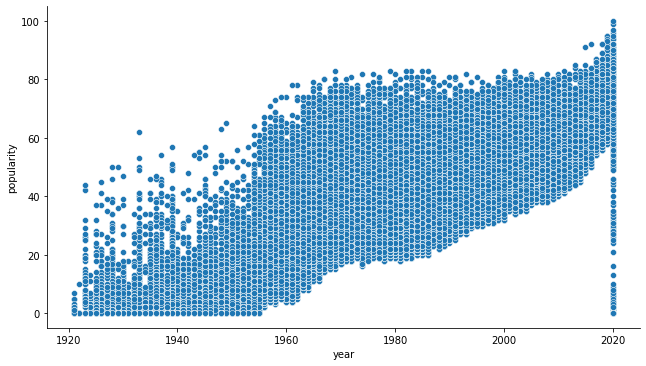

In [ ]:
sns.relplot(x="year", y="popularity", data=data_cleaned, height=5, aspect=16/9);

In [ ]:
list(data_cleaned.columns)

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'name',
 'popularity',
 'release_date',
 'speechiness',
 'tempo',
 'valence',
 'year']

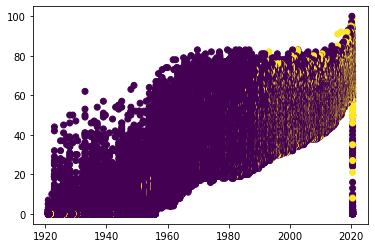

In [ ]:
plt.scatter(data_cleaned['release_date'], data_cleaned['popularity'], c=data_cleaned['explicit'])
plt.show()

In [ ]:
data_cleaned_key_cleanup = data.drop('artists', axis=1)
data_cleaned_key_cleanup = data_cleaned_key_cleanup.drop('id', axis=1)
print(data_cleaned_key_cleanup.shape)
data_cleaned_key_cleanup.head()

(169909, 17)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,0.708,158648,0.1950,0,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,0.379,282133,0.0135,0,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,0.749,104300,0.2200,0,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,0.781,180760,0.1300,0,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,0.210,687733,0.2040,0,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [ ]:
data_cleaned.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,169909.000000,169909.000000,1.699090e+05,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000
mean,0.493214,0.538150,2.314062e+05,0.488593,0.084863,0.161937,5.200519,0.206690,-11.370289,0.708556,31.556610,0.094058,116.948017,0.532095,1977.223231
std,0.376627,0.175346,1.213219e+05,0.267390,0.278679,0.309329,3.515257,0.176796,5.666765,0.454429,21.582614,0.149937,30.726937,0.262408,25.593168
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,0.094500,0.417000,1.710400e+05,0.263000,0.000000,0.000000,2.000000,0.098400,-14.470000,0.000000,12.000000,0.034900,93.516000,0.322000,1957.000000
50%,0.492000,0.548000,2.086000e+05,0.481000,0.000000,0.000204,5.000000,0.135000,-10.474000,1.000000,33.000000,0.045000,114.778000,0.544000,1978.000000
75%,0.888000,0.667000,2.629600e+05,0.710000,0.000000,0.086800,8.000000,0.263000,-7.118000,1.000000,48.000000,0.075400,135.712000,0.749000,1999.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.969000,244.091000,1.000000,2020.000000


In [ ]:
# creating a dictionary to make the keys presentable as names rather than 
# numbers
cleanup = {'key':{0:'C',1:'CD',2:'D',3:'DE',4:'E',5:'EF',6:'F',7:'FG',8:'G',
                  9:'GA',10:'A',11:'AB'},
           'mode':{1:'Major',0:'Minor'},
           'explicit':{1:'Explicit',0:'Not Explicit'}}

In [ ]:
data_cleaned_key_cleanup.replace(cleanup, inplace=True) #only run once

In [ ]:
data_cleaned_key_cleanup.head(10)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,0.708,158648,0.1950,Not Explicit,0.563,A,0.1510,-12.428,Major,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,0.379,282133,0.0135,Not Explicit,0.901,G,0.0763,-28.454,Major,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,0.749,104300,0.2200,Not Explicit,0.000,EF,0.1190,-19.924,Minor,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,0.781,180760,0.1300,Not Explicit,0.887,CD,0.1110,-14.734,Minor,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,0.210,687733,0.2040,Not Explicit,0.908,AB,0.0980,-16.829,Major,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928
5,0.995,0.424,352600,0.1200,Not Explicit,0.911,F,0.0915,-19.242,Minor,Scherzo a capriccio: Presto,0,1928,0.0593,63.521,0.2660,1928
6,0.956,0.444,136627,0.1970,Not Explicit,0.435,AB,0.0744,-17.226,Major,"Valse oubliée No. 1 in F-Sharp Major, S. 215/1",0,1928,0.0400,80.495,0.3050,1928
7,0.988,0.555,153967,0.4210,Not Explicit,0.836,CD,0.1050,-9.878,Major,Per aspera ad astra,0,1928,0.0474,123.310,0.8570,1928
8,0.995,0.683,162493,0.2070,Not Explicit,0.206,GA,0.3370,-9.801,Minor,Moneda Corriente - Remasterizado,0,1928-10-03,0.1270,119.833,0.4930,1928
9,0.846,0.674,111600,0.2050,Not Explicit,0.000,GA,0.1700,-20.119,Major,Chapter 1.3 - Zamek kaniowski,0,1928,0.9540,81.249,0.7590,1928


In [ ]:
key_data = data_cleaned_key_cleanup[['popularity','year','key']]

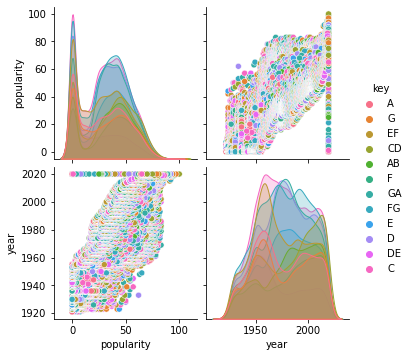

In [ ]:
sns.pairplot(key_data, hue = 'key');

In [ ]:
import plotly.express as px

In [ ]:
pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.12.0)


In [ ]:
data_cleaned_key_cleanup['key'].value_counts()

C     21499
FG    20757
D     18821
GA    17628
EF    16336
E     12921
CD    12816
A     12056
G     10711
AB    10593
F      8586
DE     7185
Name: key, dtype: int64

In [ ]:
all = 169909
C=21499/all
FG=20757/all
D=18821/all
GA=17628/all
EF=16336/all
E=12921/all
CD=12816/all
A=12056/all
G=10711/all
AB=10593/all
F=8586/all
DE=7185/all
keys=[C,FG,D,GA,EF,E,CD,A,G,AB,F,DE]
list(keys)

[0.12653243795208022,
 0.12216539441701146,
 0.11077105980260021,
 0.10374965422667427,
 0.0961455838125114,
 0.07604658964504529,
 0.07542861178630914,
 0.07095562918974274,
 0.06303962709450353,
 0.06234513769135243,
 0.05053293233436722,
 0.04228734204780206]

In [ ]:
keyavg = np.average(keys)
print(keyavg)

0.08333333333333333


In [ ]:
# we want a value that when added to the top 50 percentile of the relative sum 
# of keys the result is more positive (100%<) and adding to the bottom 50 
# percentile is more negative(100%>)
x1 = 1 - 0.12653243795208022
x2 = 1 - 0.04228734204780206
newkeyavg = (x1+x2)/2
print(newkeyavg)

0.9155901100000589


In [ ]:
keyindex = [i + newkeyavg for i in keys]
print([i + newkeyavg for i in keys])
list(keyindex)

[1.042122547952139, 1.0377555044170703, 1.0263611698026591, 1.0193397642267332, 1.0117356938125703, 0.9916366996451041, 0.991018721786368, 0.9865457391898016, 0.9786297370945624, 0.9779352476914113, 0.966123042334426, 0.9578774520478609]


[1.042122547952139,
 1.0377555044170703,
 1.0263611698026591,
 1.0193397642267332,
 1.0117356938125703,
 0.9916366996451041,
 0.991018721786368,
 0.9865457391898016,
 0.9786297370945624,
 0.9779352476914113,
 0.966123042334426,
 0.9578774520478609]

In [ ]:
data_cleaned_key_cleanup['keyrelativity'] = data_cleaned_key_cleanup['key']
data_cleaned_key_cleanup.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,keyrelativity
0,0.995,0.708,158648,0.1950,Not Explicit,0.563,A,0.1510,-12.428,Major,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928,A
1,0.994,0.379,282133,0.0135,Not Explicit,0.901,G,0.0763,-28.454,Major,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928,G
2,0.604,0.749,104300,0.2200,Not Explicit,0.000,EF,0.1190,-19.924,Minor,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928,EF
3,0.995,0.781,180760,0.1300,Not Explicit,0.887,CD,0.1110,-14.734,Minor,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928,CD
4,0.990,0.210,687733,0.2040,Not Explicit,0.908,AB,0.0980,-16.829,Major,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928,AB


In [ ]:
keyrelativity_cleanup = {'keyrelativity':{'C':1.042122547952139,
                                          'FG':1.0377555044170703,
                                          'D':1.0263611698026591,
                                          'AB':1.0193397642267332,
                                          'EF':1.0117356938125703,
                                          'E':0.9916366996451041,
                                          'CD':0.991018721786368,
                                          'A':0.9865457391898016,
                                          'G':0.9786297370945624,
                                          'AB':0.9779352476914113,
                                          'F':0.966123042334426,
                                          'DE':0.9578774520478609}}

In [ ]:
data_cleaned_key_cleanup.replace(keyrelativity_cleanup, inplace=True) #only run once

In [ ]:
data_cleaned_key_cleanup.tail(20)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,keyrelativity
169889,0.0694,0.877,234055,0.554,Explicit,0.000000,CD,0.0521,-5.905,Major,Multiple Flows (with Lil Uzi Vert),65,2020-05-29,0.3020,126.073,0.5850,2020,0.991019
169890,0.7860,0.501,192120,0.349,Explicit,0.000000,DE,0.1070,-10.883,Minor,Second Chances. (ft. 6LACK),67,2020-04-03,0.3910,72.855,0.3220,2020,0.957877
169891,0.0134,0.871,200573,0.493,Explicit,0.000241,CD,0.3850,-6.356,Major,Marsh,70,2020-01-17,0.2050,144.989,0.0495,2020,0.991019
169892,0.1990,0.636,217239,0.841,Not Explicit,0.000395,D,0.0836,-1.927,Minor,Stay Tonight,74,2020-04-27,0.0548,121.022,0.5060,2020,1.02636
169893,0.3040,0.593,207898,0.430,Not Explicit,0.000000,C,0.0896,-8.977,Major,Say You Will,69,2020-05-29,0.0431,122.090,0.0955,2020,1.04212
169894,0.5920,0.618,190183,0.428,Not Explicit,0.000000,FG,0.1920,-8.500,Minor,Young & Sad,71,2020-05-15,0.0380,142.021,0.3590,2020,1.03776
169895,0.4950,0.864,63784,0.440,Explicit,0.000000,EF,0.3200,-11.642,Minor,Vibes Only,64,2020-06-05,0.5530,137.086,0.8480,2020,1.01174
169896,0.0274,0.701,191904,0.645,Explicit,0.000174,G,0.3270,-3.084,Minor,Wet Em Up Pt. 2,67,2020-05-08,0.1640,107.955,0.5760,2020,0.97863
169897,0.0220,0.854,201907,0.599,Explicit,0.000000,CD,0.1730,-7.406,Minor,Tycoon,66,2020-05-15,0.3550,157.031,0.8490,2020,0.991019
169898,0.2540,0.506,175339,0.787,Explicit,0.000000,G,0.1120,-6.634,Major,Fine By Time,64,2020-02-21,0.1610,99.956,0.3330,2020,0.97863


In [ ]:
data_cleaned_key_cleanup['popularity'].value_counts()

0      27357
42      3280
43      3120
40      3061
44      3054
41      3016
45      2945
38      2900
39      2868
35      2858
31      2812
36      2807
46      2803
34      2791
37      2773
47      2770
32      2755
48      2750
30      2682
33      2675
49      2666
50      2623
29      2553
28      2488
27      2473
52      2462
25      2447
51      2446
26      2383
24      2373
53      2362
1       2254
23      2173
54      2165
22      2079
55      2051
56      1928
21      1885
57      1806
58      1700
60      1692
59      1629
61      1623
20      1566
62      1505
63      1454
2       1449
64      1385
19      1364
13      1326
9       1301
14      1295
10      1293
18      1260
8       1257
12      1251
11      1230
65      1223
3       1200
7       1190
16      1178
15      1144
66      1130
17      1106
4       1074
6       1074
67      1026
5       1019
68       890
69       840
70       725
71       587
72       574
73       435
74       422
75       320
76       293

In [ ]:
#feature engineering: 'relativity' calculated as some weighted index of 
#popularity and key
data_cleaned_key_cleanup['relativity'] = data_cleaned_key_cleanup['popularity'] * data_cleaned_key_cleanup['keyrelativity']
data_cleaned_key_cleanup.tail(20)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,keyrelativity,relativity
169889,0.0694,0.877,234055,0.554,Explicit,0.000000,CD,0.0521,-5.905,Major,Multiple Flows (with Lil Uzi Vert),65,2020-05-29,0.3020,126.073,0.5850,2020,0.991019,64.4162
169890,0.7860,0.501,192120,0.349,Explicit,0.000000,DE,0.1070,-10.883,Minor,Second Chances. (ft. 6LACK),67,2020-04-03,0.3910,72.855,0.3220,2020,0.957877,64.1778
169891,0.0134,0.871,200573,0.493,Explicit,0.000241,CD,0.3850,-6.356,Major,Marsh,70,2020-01-17,0.2050,144.989,0.0495,2020,0.991019,69.3713
169892,0.1990,0.636,217239,0.841,Not Explicit,0.000395,D,0.0836,-1.927,Minor,Stay Tonight,74,2020-04-27,0.0548,121.022,0.5060,2020,1.02636,75.9507
169893,0.3040,0.593,207898,0.430,Not Explicit,0.000000,C,0.0896,-8.977,Major,Say You Will,69,2020-05-29,0.0431,122.090,0.0955,2020,1.04212,71.9065
169894,0.5920,0.618,190183,0.428,Not Explicit,0.000000,FG,0.1920,-8.500,Minor,Young & Sad,71,2020-05-15,0.0380,142.021,0.3590,2020,1.03776,73.6806
169895,0.4950,0.864,63784,0.440,Explicit,0.000000,EF,0.3200,-11.642,Minor,Vibes Only,64,2020-06-05,0.5530,137.086,0.8480,2020,1.01174,64.7511
169896,0.0274,0.701,191904,0.645,Explicit,0.000174,G,0.3270,-3.084,Minor,Wet Em Up Pt. 2,67,2020-05-08,0.1640,107.955,0.5760,2020,0.97863,65.5682
169897,0.0220,0.854,201907,0.599,Explicit,0.000000,CD,0.1730,-7.406,Minor,Tycoon,66,2020-05-15,0.3550,157.031,0.8490,2020,0.991019,65.4072
169898,0.2540,0.506,175339,0.787,Explicit,0.000000,G,0.1120,-6.634,Major,Fine By Time,64,2020-02-21,0.1610,99.956,0.3330,2020,0.97863,62.6323


In [ ]:
data_cleaned_key_cleanup.dtypes

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
explicit             object
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
keyrelativity        object
relativity           object
dtype: object

In [ ]:
data_cleaned_key_cleanup['keyrelativity']=pd.to_numeric(data_cleaned_key_cleanup['keyrelativity'],errors='coerce')
data_cleaned_key_cleanup.dtypes

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
explicit             object
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
keyrelativity       float64
relativity           object
dtype: object

In [ ]:
data_cleaned_key_cleanup['relativity']=pd.to_numeric(data_cleaned_key_cleanup['relativity'],errors='coerce')

In [ ]:
fig = px.treemap(data_cleaned_key_cleanup, path=['year','key','mode'], 
                 values='popularity', color='key', 
                 color_discrete_sequence=px.colors.qualitative.G10,
                 title='Song Popularity by Year, Key and Major/Minor')
fig.show()

In [ ]:
fig = px.treemap(data_cleaned_key_cleanup, path=['key','year'], 
                 values='popularity',title='Song Popularity by Key and Year')
fig.show()

In [ ]:
fig = px.treemap(data_cleaned_key_cleanup, path=['explicit','year'], 
                 values='popularity',title='Song Popularity by Explicitness and Year')
fig.show()

In [ ]:
fig = px.treemap(data_cleaned_key_cleanup, path=['mode','key','year'],
                 values='popularity', color='mode',
                 color_discrete_map={'Major':'gold', 'Minor':'darkblue'},
                 title='Song Popularity by Major/Minor, Key and Year')
fig.show()

In [ ]:
fig = px.treemap(data_cleaned_key_cleanup, path=['year','key','mode'], values='relativity',
                 title='Song Relativity by Year, Key and Major/Minor')
fig.show()

In [ ]:
# create feature matrix
X = data_cleaned.drop('name', axis=1)
y = data_cleaned['name']

# split data - train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42
                                                    )

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(135927, 16)
(135927,)
(33982, 16)
(33982,)


In [ ]:
def get_songs():
    idx = indices[title]
    similar = list(enumerate(cos_similar[idx]))
    similar = sorted(similar , key = lambda x: x[1] , reverse = True)
    similar = similar[:11]
    indic = []
    for i in similar:
        indic.append(i[0])
    return movies['title'].iloc[indic]

## Additional preproccessing of data
Pipeline 1 - (instantiate, fit_transform)

*   OneHotEncoder
*   OrdinalEncoder
*   StandardScaler

Pipeline 2, 3, 4 - (instantiate, fit, predict)

*   KNN
*   PCA
*   t_SNE

#### Pipeline 1

In [ ]:
# normalize standardize data using pipeline (instantiate, fit, transform)
# onehotender, ordinal encoder, standard scaler in order



# Explore each to reduce dimensionality of data: KNN, PCA and t-SNE (instantiate, fit, predict) (tune after MVPs met)




#### Pipeline 2

#### Pipeline 3

#### Pipeline 4

#### Transform data to numpy array to feed into NN

In [ ]:
# transform data to np array


## Neural Network model 
Pipeline 1 - (instantiate, compile, fit)

*   RNN
*   LSTM
*   RNN (deep and wide)

## Evaluate model

## Vizualize results

## Conclusions

## Export to application

In [ ]:
# convert to json
